In [1]:
import os
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import resample
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt

In [2]:
def plot_spectrogram(data, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    print(bins)
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # plt.title(channel + f' Spectrogram {channel_name}({fmin} - {fmax}) Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()


def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = 128
    #filename = 'eeg_record30.mat'
    mat = loadmat(data_root + filename)
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AF3','F7', 'F3','FC5','T7','P7','O1', 'O2','P8','T8', 'FC6','F4','F8','AF4']  # FP2 should really be AF4
    dat.columns = labels


    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = 2, 40
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i,c in enumerate(labels)})

    # Z-transform each column
    #dat = dat.apply(zscore)

    return dat

In [3]:
data_root = '../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG Data/'
files = os.listdir(data_root)

# For each file, print # minutes of data
# for filename in files:
#     dat = get_EEG_data(data_root, filename)
#     # Compute microstates for this data
#     eegdat = dat.to_numpy()
#     print(filename, ' --->', np.round(len(eegdat)/128/60, 3))

In [4]:
def get_trial_data(trial):
    dat = get_EEG_data(data_root, files[trial])
    return dat

example_data = get_trial_data(1)
channel_names = example_data.columns
example_data

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,0.030598,-1.042316,-0.914643,0.176921,0.017885,-4.620994,-5.425149,-4.356795,-0.502782,-0.074147,-0.075766,0.040858,-0.105652,1.267994
1,1.999920,2.769463,-1.110293,-8.494444,0.739605,-2.814780,-4.678036,-2.590716,5.017268,0.472104,-2.136780,0.086290,-0.393494,-2.037869
2,4.484537,5.829628,4.158422,-9.893508,-0.183470,0.541909,-8.024098,4.241014,9.824190,0.380421,0.192974,0.119781,-0.921544,2.662517
3,4.917474,2.158804,3.772884,-6.423484,-0.215997,-6.601297,-12.685575,1.766921,7.592638,-0.107619,-0.098468,0.143687,0.069199,4.854863
4,3.817242,-4.247645,-5.192176,-1.583765,1.689969,-19.347343,-13.955797,-10.630535,1.878124,-0.087914,-4.804055,0.197885,0.154350,-0.004248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381335,0.921161,7.961519,4.830240,-0.594518,-5.031878,0.356430,3.389654,-11.105139,-1.876601,-1.016601,-71.230785,-0.264813,5.193548,9.745511
381336,0.618330,-0.111325,-3.873512,2.621598,-5.699799,-6.023455,-0.387218,-19.057653,-8.719802,-0.073293,13.225188,-0.753886,5.174892,0.810294
381337,1.100377,-1.987721,-8.688189,0.841831,-6.278456,-8.322477,-3.076204,-18.766803,-16.162587,-0.181588,36.984107,-0.463101,3.770103,-0.941950
381338,1.607395,0.591293,-5.525716,-1.454917,-4.934711,-5.063601,-1.889936,-10.950763,-13.789281,-0.531853,13.591765,0.105307,1.919611,1.198269


In [5]:
# 5 subjects, each subject did 7 trials. except the 5'th subject that did 6 trials.
#  The first 2 trials were used to get familiar with the process.

subject_map = {i: np.arange(3, 8) + 7*(i-1) for i in range(1, 5)}
subject_map[6] = np.arange(3, 7) + 7*4
subject_map

{1: array([3, 4, 5, 6, 7]),
 2: array([10, 11, 12, 13, 14]),
 3: array([17, 18, 19, 20, 21]),
 4: array([24, 25, 26, 27, 28]),
 6: array([31, 32, 33, 34])}

In [6]:
def plot_spectrogram(subject, trial, channel_name, fs, fmin, fmax):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    trial_name = subject_map[subject][trial]
    data = get_trial_data(trial_name)[channel_name]
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=128, cmap='jet')
    # Sxx[:, 600] = 2000
    # Sxx[:, 1200] = 2000
    plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Subj{subject}, trial{trial} | trail name{trial_name}, ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    plt.show()
    return Sxx

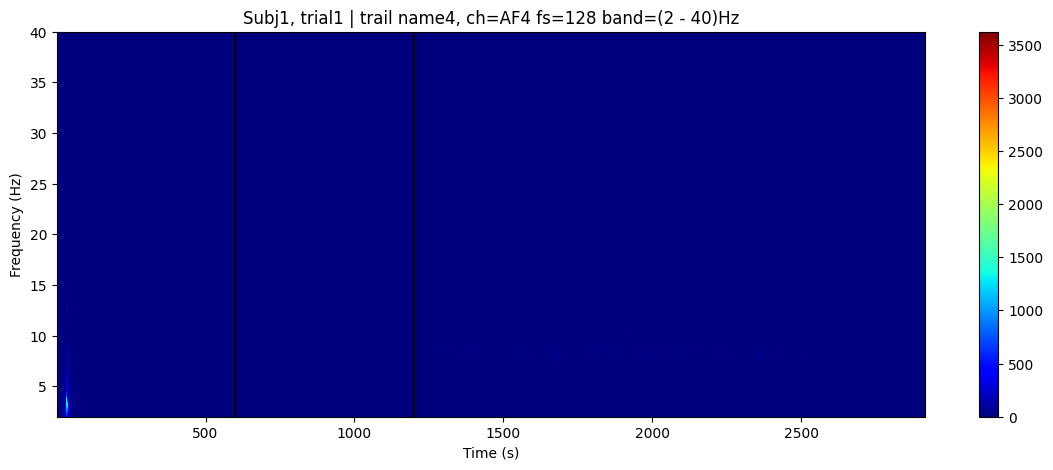

In [7]:
x = plot_spectrogram(subject=1, trial=1, channel_name='AF4', fs=128, fmin=2, fmax=40)

In [8]:
# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)


def generate_spikes(resonator, data_resampled, spikes_output_path=None):
    output_neuron = resonator.layers_neurons[-1].neurons[-1]
    resonator.input_full_data(data_resampled)
    if spikes_output_path is not None:
        np.savez_compressed(
            file=spikes_output_path,
            spikes=output_neuron.out_spikes[:output_neuron.index]
        )

In [ ]:
from snn.resonator import create_excitatory_inhibitory_resonator
from pathlib import Path
from tqdm.notebook import tqdm

clk_resonators = {
    16830: ['0.657', '1.523', '2.120', '2.504', '3.490'],
    88402: ['4.604', '5.180', '5.755', '6.791', '8.000'],
    154705: ['8.058', '9.065', '10.072', '11.885', '14.000'],
    331510:  ['15.108', '17.266', '19.424', '21.583', '25.468'],
    696172: ['36.259', '40.791', '45.324', '53.482', '63.000']
}

fs = 128
with tqdm(total=len(channel_names) * (34 - 10) * (5 * 5)) as pbar:
    for subject_name, subject_trials in subject_map.items():
        for trial in subject_trials:
            data = get_trial_data(trial)
            for ch_i, ch in enumerate(data.columns):
                ch_data = data[ch].values
                data_resampled = resample_signal(16830 / 2, fs, ch_data)
                for clk_i, (clk_freq, list_of_f0) in enumerate(clk_resonators.items()):
                    spikes_folder = f'../datasets/EEG_data_for_Mental_Attention_State_Detection/EEG_spikes/{trial}/{ch}/{clk_freq}'
                    if not os.path.exists(spikes_folder):
                        os.makedirs(spikes_folder)
                    for f_i, f0 in enumerate(list_of_f0):
                        pbar.set_description(f'trial: {trial}, ch: {ch_i}/14 clk {clk_i}/5 f:{f_i}/5')
                        pbar.update()
                        spikes_file = f'{spikes_folder}/{f0}.npz'
                        if Path(spikes_file).is_file():
                            continue
                        resonator = create_excitatory_inhibitory_resonator(
                            freq0=f0,
                            clk_freq=clk_freq)
                        resonator.log_out_spikes(-1)
                        generate_spikes(resonator, data_resampled, spikes_file)


  0%|          | 0/8400 [00:00<?, ?it/s]

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
